# Northwind Salesmen Database

Chien-Lan Hsueh

## Northwind


To get an idea of the performance of the various salesmen and women at Northwind, and any areas where there is room for improvement, we need to look at their numbers from multiple different angles. More specifically, we'll look at how much they've sold, and of what products, across different years and regions. 

### Part 1: Load module, define a helper function and read in tables from database
To begin, we need to load the various modules we'll be using. To retrieve the tables of interest from the database, we use `sqlite3`.  For analysis, we make use of `numPy` and `pandas`, and for visualization `matplotlib`. We also make use of the `datetime` module for formatting. 

#### Import python modules

In [3]:
# import modules used in this assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime

# supress a warning due to a bug in the current version of matplotlib
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

#### Helper functions: 
For efficiency, we also define a few helper functions. As we will be joining many different tables, we first define a function capable of joining many functions at once, with the option to output the methods used for clarity. Next, as pandas truncates output by default, we define a function to print the dataframe and/or series in its entirety. Finally, for more complex visualizations and formatting ease, we define a plotting function to allow us to plot and format univariate and bivariate data on a single and dual y-axis. 

In [4]:
# join the selected data frames
def joinDF(dct_df, df0, lst_joining, verbose = False):
    """
    Join data frames
    dct_df: dictionary of data frames
    df0: name of data frame to start with
    lst_joining: list of inputs in each joining operation [name of data frame, key]
    verbose: enable/disable verbose output
    """
    
    # data frame to start with
    df = dct_df[df0]
    
    # join data frames on sepecified key
    for table, key in lst_joining:
        # verbose output during joining
        if verbose:
            print(f"Joining table '{table}' on key '{key}'")
        df = pd.merge(df, dct_tables[table], on = key, how = "left")

    # verbose output of the result
    if verbose:
        # show info of resulting data frame
        display(df.shape)
        display(df.columns)
        display(df.head())
    
    return df

In [5]:
# pretty-print an entire Pandas Series / DataFrame / collections
def display_full(x):
    """
    Print out whole content
    x: objects to print
    """
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

In [6]:
# a convenient plotting function for X, X-Y1 or X-Y1/X-Y2 plots
def plotDF(df, XY = {"title": "Plot Title"}, Y2 = None, FIG = None, ax = None, by = None, suptitle = None):
    """
    A wrapper of pandas.DataFrame.plot() function for plots of univariate, bi-variate on single or dual y-axis
    df: dataframe
    XY: Dict with keywords passed to pandas.DataFrame.plot() to plot on primary y-axis
    Y2: Dict with keywords passed to pandas.DataFrame.plot() to plot on secondary y-axis
    FIG: Dict with keywords passed to matplotlib.pyplot.subplots() to create a figure and a set of subplots
    ax: matplotlib.axes.Axe object
    by: mapping, function, label, list of labels or Dict with keywords passed to pandas.DataFrame.groupby()
    suptitle: a suptitle of the figure
    """
    
    # initiate FIG if there is none
    FIG = {} if FIG is None else FIG    
    
    # plot multiple subplots
    if by is not None:
        # convert to a dict as kwargs passed to pandas.DataFrame.groupby()
        GRP = by if isinstance(by, dict) else {"by": by}
        # sort = False by default if there is no sort 
        GRP = GRP if "sort" in GRP.keys() else GRP | {"sort": False}
        
        # subset data and get dataframes for each subplot
        dct_dfs = dict(tuple(df.groupby(**GRP)))
        lst_keys = list(dct_dfs.keys())        
        # number of subplots
        n = len(lst_keys)
        
        # decide subplot grid size        
        FIG["nrows"], FIG["ncols"] = FIG.get("nrows", 1), FIG.get("ncols", 1)
        if FIG["nrows"] * FIG["ncols"] < n:
            # decide nrows first
            FIG["nrows"] = np.ceil(n / FIG["ncols"]).astype(int) if FIG["nrows"] == 1 else FIG["nrows"]
            # calculate ncols
            FIG["ncols"] = np.ceil(n / FIG["nrows"]).astype(int)
        
        # create a figure and a set of subplots
        fig, axs = plt.subplots(**FIG)
        # reshape axs 2-D array into 1-D array
        axs1D = axs.flatten()
                
        # plot subplots in turn by calling itself
        axs = [
            plotDF(dct_dfs[i], XY | {"title": f"{i}"}, Y2, ax = axs1D[lst_keys.index(i)]) 
            for i in lst_keys]
        
        # add a centered suptitle to the figure.
        suptitle = f"By {by}" if suptitle is None else suptitle             
        plt.suptitle(suptitle)
                
        return axs
    
    # plot a single plot   
    else:
        # create a figure and a set of subplots if there is no axes object
        if ax is None:
            fig, ax = plt.subplots(**FIG)
               
        # plot X or XY depending on if Y2 exists
        df.plot(ax = ax, **XY)
        ax.set_xlabel(XY["xlabel"]) if "xlabel" in XY.keys() else None            
        
        # set y-axis color
        ax.set_ylabel(XY["ylabel"]) if "ylabel" in XY.keys() else None
        ax.yaxis.label.set_color("blue")
        ax.tick_params(axis = "y", colors = "blue")
        
        # plot X-Y2 on secondary y axis if Y2 exists
        if Y2 is not None:
            # update XY: remove the primary y-axis' label and add Y2
            XY.pop("ylabel", None)
            XY = XY | Y2
            
            # plot on a twin Axes sharing the x-axis with update kwargs for the pandas plot function
            ax2 = df.plot(ax = ax.twinx(), **XY)
            
            # set y-axis color
            ax2.yaxis.label.set_color("green")
            ax2.tick_params(axis = "y", colors = "green")
            
        return ax

### Part 2: Read in and prepare tables
As a final prepatory step before the analysis, we read and in and join tables where appropriate.

#### Read in tables

Connect to the database and get the table infomation from the schema table:

In [7]:
# connect to the database
con = sqlite3.connect("northwind.sqlite")

# get info of all tables
df_tables = pd.read_sql("SELECT * FROM sqlite_schema WHERE type = 'table';", con)
df_tables

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
3,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
4,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
7,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
8,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
9,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...


Choosing the tables we are going to use in this study via SQL query, then taking a look at the shape and contents:

In [8]:
# define SQL query template
sql_template = '''
	SELECT *
	FROM '_table_';
	'''

# tables of interest 
lst_tables = ["Employees", "EmployeeTerritories", "Territories", "Regions", "Orders", "Order Details", "Products", "Categories"]

# initialize an empty dictionary to save the tables
dct_tables = {}

# read and get info of each table
for i in lst_tables:
    sql_query = sql_template.replace("_table_", i)
    
    # execute query and get the results
    df = pd.read_sql(sql_query, con)
        
    # print related info
    print(f"Table: {i}")
    print(f"Dimension: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())  
    
    # add to the dictionary
    dct_tables[i] = df

Table: Employees
Dimension: (9, 18)
Columns: ['EmployeeID', 'LastName', 'FirstName', 'Title', 'TitleOfCourtesy', 'BirthDate', 'HireDate', 'Address', 'City', 'Region', 'PostalCode', 'Country', 'HomePhone', 'Extension', 'Photo', 'Notes', 'ReportsTo', 'PhotoPath']


,EmployeeID,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1948-12-08,1992-05-01,507 - 20th Ave. E.Apt. 2A,Seattle,WA,98122,USA,(206) 555-9857,5467,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1952-02-19,1992-08-14,908 W. Capital Way,Tacoma,WA,98401,USA,(206) 555-9482,3457,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1963-08-30,1992-04-01,722 Moss Bay Blvd.,Kirkland,WA,98033,USA,(206) 555-3412,3355,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1937-09-19,1993-05-03,4110 Old Redmond Rd.,Redmond,WA,98052,USA,(206) 555-8122,5176,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1955-03-04,1993-10-17,14 Garrett Hill,London,None,SW1 8JR,UK,(71) 555-4848,3453,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


Table: EmployeeTerritories
Dimension: (49, 2)
Columns: ['EmployeeID', 'TerritoryID']


,EmployeeID,TerritoryID
0,1,06897
1,1,19713
2,2,01581
3,2,01730
4,2,01833


Table: Territories
Dimension: (53, 3)
Columns: ['TerritoryID', 'TerritoryDescription', 'RegionID']


,TerritoryID,TerritoryDescription,RegionID
0,01581,Westboro ...,1
1,01730,Bedford ...,1
2,01833,Georgetow ...,1
3,02116,Boston ...,1
4,02139,Cambridge ...,1


Table: Regions
Dimension: (4, 2)
Columns: ['RegionID', 'RegionDescription']


,RegionID,RegionDescription
0,1,Eastern ...
1,2,Westerns ...
2,3,Northern ...
3,4,Southern ...


Table: Orders
Dimension: (830, 14)
Columns: ['OrderID', 'CustomerID', 'EmployeeID', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']


,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,1996-07-04 00:00:00.000,1996-08-01 00:00:00.000,1996-07-16 00:00:00.000,3,32.38,Vins et alcools Chevalier,59 rue de l-Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,1996-07-05 00:00:00.000,1996-08-16 00:00:00.000,1996-07-10 00:00:00.000,1,11.61,Toms SpezialitÃ¤ten,Luisenstr. 48,MÃ¼nster,None,44087,Germany
2,10250,HANAR,4,1996-07-08 00:00:00.000,1996-08-05 00:00:00.000,1996-07-12 00:00:00.000,2,65.83,Hanari Carnes,"Rua do PaÃ§o, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,1996-07-08 00:00:00.000,1996-08-05 00:00:00.000,1996-07-15 00:00:00.000,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,None,69004,France
4,10252,SUPRD,4,1996-07-09 00:00:00.000,1996-08-06 00:00:00.000,1996-07-11 00:00:00.000,2,51.30,SuprÃªmes dÃ©lices,"Boulevard Tirou, 255",Charleroi,None,B-6000,Belgium


Table: Order Details
Dimension: (2155, 5)
Columns: ['OrderID', 'ProductID', 'UnitPrice', 'Quantity', 'Discount']


,OrderID,ProductID,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


Table: Products
Dimension: (77, 10)
Columns: ['ProductID', 'ProductName', 'SupplierID', 'CategoryID', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued']


,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


Table: Categories
Dimension: (8, 4)
Columns: ['CategoryID', 'CategoryName', 'Description', 'Picture']


,CategoryID,CategoryName,Description,Picture
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
2,3,Confections,"Desserts, candies, and sweet breads",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
3,4,Dairy Products,Cheeses,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00...


#### Prep the tables
After seeing the loaded tables in the previous step, we have better ideas on how to prepare (or condition) them before we use them in our analysis. These include mutating certain columns in the following tables:
- `Orders` table: Convert datetime columns, calculate order leadtime and get year and quarter of each order
- `Employees` table: Convert all datetime columns, calculate length of his/her employement and add employees' full names 
- `Order Details` table: Calculate sale amount for each product in each order
- `Products` table: Rename `UnitPrice` to avoid variable name conflict in `Order Details` table
- `Regions` and `Territories` tables: Remove excessive whitespace in the description columns

In `Orders` table, we seek to:
- find out the range of the dates for the orders recorded in this database: `date_begin` and `date_end`
- convert all datetime-realted columns (string to datetime data type)
- calculate the leadtime (duration between `OrderDate` and `ShippedDate`) in days and note whether the order has been shipped
- get the year and quarter of each date

In [9]:
# get the date ranges of the order data
date_begin = dct_tables["Orders"][["OrderDate", "RequiredDate", "ShippedDate"]].astype('datetime64[ns]').min().min()
date_end = dct_tables["Orders"][["OrderDate", "RequiredDate", "ShippedDate"]].astype('datetime64[ns]').max().max()

# date range of this order data
print(f"This database contains the order data from {date_begin.strftime('%x')} to {date_end.strftime('%x')}:")

# Orders table: convert datetime columns and calculate the orders' leadtimes
dct_tables["Orders"] = dct_tables["Orders"] \
    .assign(
        OrderDate = lambda x: pd.to_datetime(x["OrderDate"]), 
        RequiredDate = lambda x: pd.to_datetime(x["RequiredDate"]),
        ShippedDate = lambda x: pd.to_datetime(x["ShippedDate"]),
        Leadtime= lambda x: (x["ShippedDate"] - x["OrderDate"]).dt.days.astype("Int64"),
        OrderShipped = lambda x: ~np.isnat(x["ShippedDate"]),
        Year = lambda x: x["OrderDate"].dt.year,
        YearQuarter = lambda x: x["OrderDate"].dt.to_period("Q"),
        YearMonth = lambda x: x["OrderDate"].dt.to_period("M"))

# take a look at the last couple orders
dct_tables["Orders"][["OrderID", "OrderDate", "RequiredDate", "ShippedDate", "Leadtime", "OrderShipped", "Year", "YearQuarter", "YearMonth"]]

This database contains the order data from 07/04/96 to 06/11/98:


,OrderID,OrderDate,RequiredDate,ShippedDate,Leadtime,OrderShipped,Year,YearQuarter,YearMonth
0,10248,1996-07-04,1996-08-01,1996-07-16,12,True,1996,1996Q3,1996-07
1,10249,1996-07-05,1996-08-16,1996-07-10,5,True,1996,1996Q3,1996-07
2,10250,1996-07-08,1996-08-05,1996-07-12,4,True,1996,1996Q3,1996-07
3,10251,1996-07-08,1996-08-05,1996-07-15,7,True,1996,1996Q3,1996-07
4,10252,1996-07-09,1996-08-06,1996-07-11,2,True,1996,1996Q3,1996-07
...,...,...,...,...,...,...,...,...,...
825,11073,1998-05-05,1998-06-02,NaT,<NA>,False,1998,1998Q2,1998-05
826,11074,1998-05-06,1998-06-03,NaT,<NA>,False,1998,1998Q2,1998-05
827,11075,1998-05-06,1998-06-03,NaT,<NA>,False,1998,1998Q2,1998-05
828,11076,1998-05-06,1998-06-03,NaT,<NA>,False,1998,1998Q2,1998-05


In `Employees` table, we:
- convert all datetime columns
- calculate lengths of employment (`Tenure`) in years (duration between hiring date and `date_end`)
- add employees' full names for reporting purposes

In [10]:
# Employees table: add a new coulmn of employees' names
dct_tables["Employees"] = dct_tables["Employees"] \
    .assign(
        BirthDate = lambda x: pd.to_datetime(x["BirthDate"]),
        HireDate = lambda x: pd.to_datetime(x["HireDate"]),
        Tenure= lambda x: round((date_end - x["HireDate"]).dt.days / 365, 1),
        Name = lambda x: x["FirstName"] + " " + x["LastName"])
     
dct_tables["Employees"][["EmployeeID", "Name", "Title", "Tenure"]]

,EmployeeID,Name,Title,Tenure
0,1,Nancy Davolio,Sales Representative,6.1
1,2,Andrew Fuller,"Vice President, Sales",5.8
2,3,Janet Leverling,Sales Representative,6.2
3,4,Margaret Peacock,Sales Representative,5.1
4,5,Steven Buchanan,Sales Manager,4.7
5,6,Michael Suyama,Sales Representative,4.7
6,7,Robert King,Sales Representative,4.4
7,8,Laura Callahan,Inside Sales Coordinator,4.3
8,9,Anne Dodsworth,Sales Representative,3.6


In `Order Details` table, to get a clearer picture of the revenue generated in a given sale, we calculate sale amount for each products in an order. First, we notice that the `Discount` column is the discount percentages, and needs to be accounted for in the calculations:

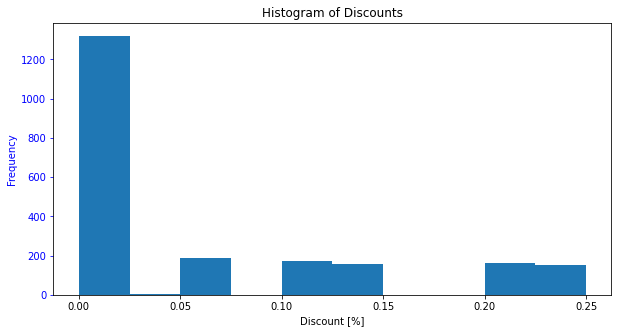

In [11]:
# take a look at the discounts by plotting the histogram
df = dct_tables["Order Details"]["Discount"]
XY = {"xlabel": "Discount [%]", "title": "Histogram of Discounts", "kind": "hist"}
FIG = {"figsize": (10, 5)}
plotDF(df, XY, FIG = FIG)
plt.show()

 Therefore, the sale amount for each product can be calculated by:
  
 $\text{SaleAmount} = \text{UnitPrice} * \text{Quantity} * (1 - \text{Discount})$

In [12]:
# Order Details table: calculate sale amount
dct_tables["Order Details"] = dct_tables["Order Details"] \
    .assign(SaleAmount = lambda x: x["UnitPrice"] * x["Quantity"] *(1 - x["Discount"]))

dct_tables["Order Details"]

,OrderID,ProductID,UnitPrice,Quantity,Discount,SaleAmount
0,10248,11,14.00,12,0.00,168.000
1,10248,42,9.80,10,0.00,98.000
2,10248,72,34.80,5,0.00,174.000
3,10249,14,18.60,9,0.00,167.400
4,10249,51,42.40,40,0.00,1696.000
...,...,...,...,...,...,...
2150,11077,64,33.25,2,0.03,64.505
2151,11077,66,17.00,1,0.00,17.000
2152,11077,73,15.00,2,0.01,29.700
2153,11077,75,7.75,4,0.00,31.000


 The `Unitprice` is listed on both the `Products` and `Order Details` tables but they are not the same: 
 - The `UnitPrice` in the `Products` table is the *listed* unit price of the product. 
 - The `UnitPrice` in the `Order Details` table is the unit price that the customer actually paid.

 We should use the "UnitPrice" in the `Order Details` table to correctly calculate sale amount. To avoid the name conflict in the later data manipulation, we rename the *listed* `UnitPrice` in `Products` table as `ListedUnitPrice`:

In [13]:
# Products table: rename UnitPrice column
dct_tables["Products"].rename(columns = {"UnitPrice": "ListedUnitPrice"}, inplace = True)
dct_tables["Products"]

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,ListedUnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,RÃ¶d Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,RhÃ¶nbrÃ¤u Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,LakkalikÃ¶Ã¶ri,23,1,500 ml,18.00,57,0,20,0


In the `Regions` and `Territories` tables, we simply remove the whitespace in the description columns `RegionDescription` and `TerritoryDescription` respectively:

In [14]:
dct_tables["Regions"]["RegionDescription"] = dct_tables["Regions"]["RegionDescription"].str.strip()
dct_tables["Territories"]["TerritoryDescription"] = dct_tables["Territories"]["TerritoryDescription"].str.strip()

display(dct_tables["Regions"]["RegionDescription"])
display(dct_tables["Territories"]["TerritoryDescription"].head())

0     Eastern
1    Westerns
2    Northern
3    Southern
Name: RegionDescription, dtype: object

0     Westboro
1      Bedford
2    Georgetow
3       Boston
4    Cambridge
Name: TerritoryDescription, dtype: object

#### Remove image data
Finally, since we are not going to use the image data in this study, removing them helps improve the computing efficiency.
- `Employees` table: `Photo`
- `Categories` table: `Picture`

In [15]:
# drop the columns of image data
dct_tables["Employees"].drop(columns = "Photo", inplace = True)
dct_tables["Categories"].drop(columns = "Picture", inplace = True)

### Part 3: Analysis

#### Who are the employees and what territories do they cover?
Before we can answer the relevant questions at hand, we need to gain some further clarity about the team through an exploratory data analysis. We will start our EDA with their names, titles, lengths of employement and sale territories they cover. This information can be obtained by joining the following tables from the database:
- `Employees` table
- `EmployeeTerritories` table
- `Territories` table
- `Regions` table

In [16]:
# define tables to be joined and the keys to be used for employee and region data
lst_df_to_join = [
    ["EmployeeTerritories", "EmployeeID"], 
    ["Territories", "TerritoryID"], 
    ["Regions", "RegionID"]
]

# Join Employees, EmployeeTerritories, Territories and Regions tables
df_team = joinDF(dct_tables, "Employees", lst_df_to_join) \
    .groupby(["EmployeeID", "Name", "Title", "Tenure", "RegionDescription"]) \
    .agg(Territories = ("TerritoryID", "nunique")) \
    .reset_index()

# save the dataframe for later use
dct_tables["team"] = df_team

# print employee summary table nicely
display(df_team.set_index(["EmployeeID", "Name", "Title", "Tenure"]))

# print the title, tenure and territory coverage of each employee
for x in df_team.index:
    print(
        f"{df_team['Name'][x]} ({df_team['Title'][x]}, {round(df_team['Tenure'][x], 1)} yrs of tenure) "
        f"covers {df_team['Territories'][x]} territories in {df_team['RegionDescription'][x]} region.")

print(
    f"\nBetween {date_begin.strftime('%x')} and {date_end.strftime('%x')}, "
    f"the company had {df_team['EmployeeID'].nunique()} employees (listed above) in the team to "
    f"cover {df_team['Territories'].sum()} sale territories in {df_team['RegionDescription'].nunique()} regions.")


,,,,RegionDescription,Territories
EmployeeID,Name,Title,Tenure,,
1,Nancy Davolio,Sales Representative,6.1,Eastern,2
2,Andrew Fuller,"Vice President, Sales",5.8,Eastern,7
3,Janet Leverling,Sales Representative,6.2,Southern,4
4,Margaret Peacock,Sales Representative,5.1,Eastern,3
5,Steven Buchanan,Sales Manager,4.7,Eastern,7
6,Michael Suyama,Sales Representative,4.7,Westerns,5
7,Robert King,Sales Representative,4.4,Westerns,10
8,Laura Callahan,Inside Sales Coordinator,4.3,Northern,4
9,Anne Dodsworth,Sales Representative,3.6,Northern,7


Nancy Davolio (Sales Representative, 6.1 yrs of tenure) covers 2 territories in Eastern region.
Andrew Fuller (Vice President, Sales, 5.8 yrs of tenure) covers 7 territories in Eastern region.
Janet Leverling (Sales Representative, 6.2 yrs of tenure) covers 4 territories in Southern region.
Margaret Peacock (Sales Representative, 5.1 yrs of tenure) covers 3 territories in Eastern region.
Steven Buchanan (Sales Manager, 4.7 yrs of tenure) covers 7 territories in Eastern region.
Michael Suyama (Sales Representative, 4.7 yrs of tenure) covers 5 territories in Westerns region.
Robert King (Sales Representative, 4.4 yrs of tenure) covers 10 territories in Westerns region.
Laura Callahan (Inside Sales Coordinator, 4.3 yrs of tenure) covers 4 territories in Northern region.
Anne Dodsworth (Sales Representative, 3.6 yrs of tenure) covers 7 territories in Northern region.

Between 07/04/96 and 06/11/98, the company had 9 employees (listed above) in the team to cover 49 sale territories in 4 reg

#### How much do they sell?
The first question to be addressed is the first to come to mind when evaluating employee's performance: How much are they able to sell?
The `Orders` table records the order date and shipped date for every orders the company took. After examining the leadtime, we notice that not all of the orders have shipped dates indicating some orders were not completed. This would need to be accounted for in any sale revenue calculations. 

,Leadtime [days],Value
0,count,809.00
1,mean,8.49
2,std,6.84
3,min,1.00
4,25%,4.00
5,50%,7.00
6,75%,9.00
7,max,37.00
8,missing,21.00
9,TotalCount,830.00


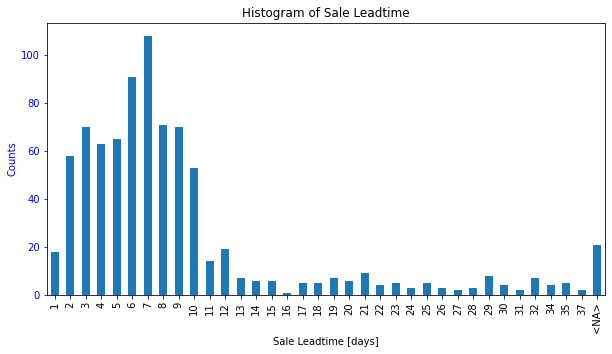

The company had received 830 sale orders. There were 21 orders which were not shipped by the end of this period. For the rest of 809 shipped orders, the order leadtime had a mean of 8.49 days and ranged from 1.00 to 37.00 days.


In [17]:
# inspect distribution of order leadtime
df_leadtime = dct_tables['Orders']['Leadtime']

# numeric summary of order leadtime (including the count of unshipped orders)
dct_leadtime_summary = pd.concat([
    df_leadtime.describe().round(2), 
    pd.Series(
        [df_leadtime.isna().sum(), len(df_leadtime)],
        index = ["missing", "TotalCount"]
    )
]).to_dict()

# print the numeric summary of order leadtime
display(pd.DataFrame(list(dct_leadtime_summary.items()), columns=['Leadtime [days]', 'Value']))

# plot the histogram of order leadtime (including the count of unshipped orders)
XY = {"x": "index", "xlabel": "Sale Leadtime [days]", "ylabel": "Counts", "title": "Histogram of Sale Leadtime", "kind": "bar"}
FIG = {"figsize": (10, 5)}
plotDF(df_leadtime.value_counts(dropna = False).sort_index(), XY, FIG = FIG)
plt.show()

print(
   f"The company had received {dct_leadtime_summary['TotalCount']:.0f} sale orders. "   
   f"There were {dct_leadtime_summary['missing']:.0f} orders which were not shipped by the end of this period. "
   f"For the rest of {dct_leadtime_summary['count']:.0f} shipped orders, "
   f"the order leadtime had a mean of {dct_leadtime_summary['mean']:.2f} days "
   f"and ranged from {dct_leadtime_summary['min']:.2f} to {dct_leadtime_summary['max']:.2f} days.")

Now, we seek to get information on the type of orders the employees handle. To get an idea of the diversity of orders, we look at how many customers are ordering what kind of products. From this we can gleam how many different people are ordering--is a salesperson bringing in multiple different customers or simply landing a few with a high demand. Similarly, what kind of products are the most successful? This information of the sales orders can be obtained by joining the following tables from the database:
- `Orders` table
- `Order Details` table
- `Products` table
- `Categories` table
- `team` table

In [18]:
# define tables to be joined and the keys to be used for sales data
lst_df_to_join = [
    ["Order Details", "OrderID"], 
    ["Products", "ProductID"], 
    ["Categories", "CategoryID"],
    ["team", "EmployeeID"]
]

# sales data - join the tables listed above for all sale order records 
df_sales = joinDF(dct_tables, "Orders", lst_df_to_join).reset_index()

# save the dataframe for later use
dct_tables["sales"] = df_sales

display(df_sales[["OrderID", "ProductID", "CategoryID", "CustomerID"]].agg([pd.Series.nunique]))

print(
   f"The {df_sales['OrderID'].nunique()} sale orders they received were from {df_sales['CustomerID'].nunique()} customers and "
   f"included {df_sales['ProductID'].nunique()} types of products in {df_sales['CategoryID'].nunique()} categories.")

,OrderID,ProductID,CategoryID,CustomerID
nunique,830,77,8,89


The 830 sale orders they received were from 89 customers and included 77 types of products in 8 categories.


With the joined `df_sales` dataframe, we can link this information to the salespeople to answer the questions previously posed about how many types of products and how much the company sold to whom. Furthermore, we can compare those from all received orders with those unshipped orders, and calculate the portions to ensure any metrics are not erroneously inflated.

In [19]:
# get numbers of received orders, products and total sale amount in each product category: received orders
df_orders_received = df_sales \
    .assign(OrderStatus = "Received") \
    .groupby(["CategoryName", "Description", "OrderStatus"]) \
    .agg(
        Orders = ("OrderID", "nunique"),
        Products = ("ProductID", "nunique"),
        TotalSaleAmount = ("SaleAmount", lambda x: x.sum()/1000)) \
    .rename(columns={"TotalSaleAmount": "TotalSaleAmount [$1k]"})

# get numbers of shipped orders, products and total sale amount in each product category: shipped orders
df_orders_shipped = df_sales.query("OrderShipped == True")\
    .assign(OrderStatus = "Shipped") \
    .groupby(["CategoryName", "Description", "OrderStatus"]) \
    .agg(
        Orders = ("OrderID", "nunique"),
        Products = ("ProductID", "nunique"),
        TotalSaleAmount = ("SaleAmount", lambda x: x.sum()/1000)) \
    .rename(columns={"TotalSaleAmount": "TotalSaleAmount [$1k]"})

# get the percentage of shipped orders count for recognized revenue
df_orders_completeness = df_orders_shipped.reset_index("OrderStatus", drop = True) \
    .div(df_orders_received.reset_index("OrderStatus", drop = True)) \
    .mul(100) \
    .assign(OrderStatus = "[%]") \
    .set_index("OrderStatus", append = True)

# concat summary tables of the received orders, the shipped orders and the shippment percentages
df_orders_summary = pd.concat([df_orders_received, df_orders_shipped, df_orders_completeness]) \
    .reset_index() \
    .pivot(
        index=["CategoryName", "Description"], 
        columns=["OrderStatus"], 
        values =["Orders", "Products", "TotalSaleAmount [$1k]"]) \
    .drop(columns = [("Products", "Shipped"), ("Products", "[%]")], axis = 1) \
    .set_index(("Products", "Received"), append=True) \
    .rename_axis(index = {('Products', 'Received'): "Products"}, columns = {'OrderStatus': None})

# print the order summary table nicely
display(df_orders_summary)

print(    
    f"Among the {df_sales['OrderID'].nunique()} received orders, there are "
    f"{df_sales['ProductID'].nunique()} types of products in {df_sales['CategoryID'].nunique()} categories and "
    f"the total booked order amount is ${round(df_orders_received['TotalSaleAmount [$1k]'].sum()*1000, 2):,.2f} dollars. "
    f"Because of the {dct_tables['Orders'].query('OrderShipped == False').shape[0]} unshipped orders, "
    f"the recognized total sales revenue is ${round(df_orders_shipped['TotalSaleAmount [$1k]'].sum()*1000, 2):,.2f} dollars.")

Orders  \
                                                                           Received   
CategoryName   Description                                        Products            
Beverages      Soft drinks, coffees, teas, beers, and ales        12.0        354.0   
Condiments     Sweet and savory sauces, relishes, spreads, and... 12.0        193.0   
Confections    Desserts, candies, and sweet breads                13.0        295.0   
Dairy Products Cheeses                                            10.0        303.0   
Grains/Cereals Breads, crackers, pasta, and cereal                7.0         182.0   
Meat/Poultry   Prepared meats                                     6.0         161.0   
Produce        Dried fruit and bean curd                          5.0         129.0   
Seafood        Seaweed and fish                                   12.0        291.0   

                                                                                    \
                                                                           Shipped   
CategoryName   Description                                        Products           
Beverages      Soft drinks, coffees, teas, beers, and ales        12.0       343.0   
Condiments     Sweet and savory sauces, relishes, spreads, and... 12.0       189.0   
Confections    Desserts, candies, and sweet breads                13.0       286.0   
Dairy Products Cheeses                                            10.0       294.0   
Grains/Cereals Breads, crackers, pasta, and cereal                7.0        179.0   
Meat/Poultry   Prepared meats                                     6.0        157.0   
Produce        Dried fruit and bean curd                          5.0        122.0   
Seafood        Seaweed and fish                                   12.0       284.0   

                                                                                       \
                                                                                  [%]   
CategoryName   Description                                        Products              
Beverages      Soft drinks, coffees, teas, beers, and ales        12.0      96.892655   
Condiments     Sweet and savory sauces, relishes, spreads, and... 12.0      97.927461   
Confections    Desserts, candies, and sweet breads                13.0      96.949153   
Dairy Products Cheeses                                            10.0      97.029703   
Grains/Cereals Breads, crackers, pasta, and cereal                7.0       98.351648   
Meat/Poultry   Prepared meats                                     6.0       97.515528   
Produce        Dried fruit and bean curd                          5.0       94.573643   
Seafood        Seaweed and fish                                   12.0      97.594502   

                                                                           TotalSaleAmount [$1k]  \
                                                                                        Received   
CategoryName   Description                                        Products                         
Beverages      Soft drinks, coffees, teas, beers, and ales        12.0                267.868180   
Condiments     Sweet and savory sauces, relishes, spreads, and... 12.0                106.047085   
Confections    Desserts, candies, and sweet breads                13.0                167.357225   
Dairy Products Cheeses                                            10.0                234.507285   
Grains/Cereals Breads, crackers, pasta, and cereal                7.0                  95.744587   
Meat/Poultry   Prepared meats                                     6.0                 163.022359   
Produce        Dried fruit and bean curd                          5.0                  99.984580   
Seafood        Seaweed and fish                                   12.0                131.261737   

                                                                                        \
 

Among the 830 received orders, there are 77 types of products in 8 categories and the total booked order amount is $1,265,793.04 dollars. Because of the 21 unshipped orders, the recognized total sales revenue is $1,239,855.61 dollars.


According to the gereral accounting rule, we should not recognize those incomplete orders when we calculate the sale revenue for this period. Therefore, we will only consider the recognized revenue from the sales of the orders which have been shipped. This can be easily done by subsetting `df_sales`:

 `df_sales.query("OrderShipped == True")`.

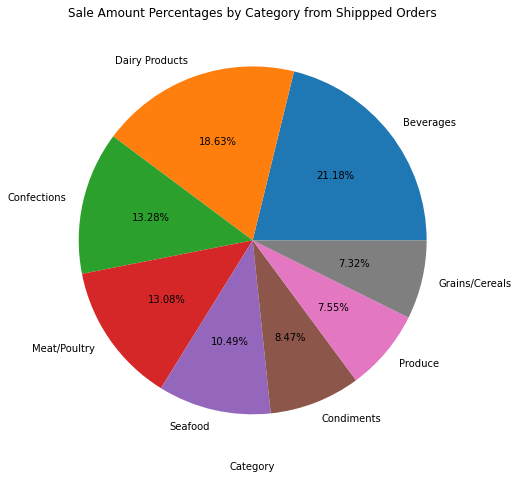

,TotalSaleAmount [$1k]
CategoryName,
Beverages,262.572480
Dairy Products,230.951165
Confections,164.672052
Meat/Poultry,162.132209
Seafood,130.070137
Condiments,105.047185
Produce,93.630797
Grains/Cereals,90.779582


The total recognized revenue from 809 shipped orders is $1,239,855.61 dollars, which is 97.95% of the total sale amount from the received orders.
The categories of two highest sale amounts are ['Beverages', 'Dairy Products'].
The categories of two lowest sale amounts are ['Grains/Cereals', 'Produce']


In [20]:
# subset the shipped orders for recognized revenue
df_revenue = df_sales.query("OrderShipped == True")

# prepare data for a pie plot to show sale amount portion by category
df = df_revenue \
    .pivot_table(
        index = ["CategoryName"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .sort_values("SaleAmount", ascending = False) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"})

# plot pie chart in descending order of total sale amount
XY = {"x": "CategoryName", "y": "TotalSaleAmount [$1k]", "kind": "pie",
      "xlabel": "Category", "ylabel": "", "title": "Sale Amount Percentages by Category from Shippped Orders", "legend": False, 
      "autopct": "%.2f%%", "startangle": 0}
FIG = {"figsize": (8, 8)}
plotDF(df, XY, FIG=FIG)
plt.show()

# print the total sale amount
display(df)

print(
    f"The total recognized revenue from {df_revenue['OrderID'].nunique()} shipped orders is "
    f"${df_revenue['SaleAmount'].sum():,.2f} dollars, "
    f"which is {df_revenue['SaleAmount'].sum()/df_sales['SaleAmount'].sum():.2%} of the total sale amount from the received orders.\n"
    f"The categories of two highest sale amounts are {list(df.index)[:2]}.\n"
    f"The categories of two lowest sale amounts are {list(df.index)[:-3:-1]}")

Now that we have a reliable metric for the total sales amount, we can further examine its composition. Looking at products that are most popular at Northwind, we can see that beverages and dairy products are the company's top performers. 

#### What products are they able to sell?
To further refine the above information, we further dissect what products each employee sold--and how much. We can make a pivot table to neatly display this information from the revenue dataframe `df_revenue`:

In [21]:
# get sale amounts and products of each employee
df = df_revenue \
    .pivot_table(
        index = ["CategoryName", "ProductName"],
        columns = ["EmployeeID", "Name"],
        values = "SaleAmount",
        aggfunc = sum,
        margins = True)

# print out the whole pivolt table
display_full(df)

EmployeeID                                                   1             2  \
Name                                             Nancy Davolio Andrew Fuller   
CategoryName   ProductName                                                     
Beverages      Chai                                   990.9000        900.00   
               Chang                                 2922.2000        736.25   
               Chartreuse verte                      1862.6400       1368.00   
               CÃ´te de Blaye                       23570.0750      25190.60   
               GuaranÃ¡ FantÃ¡stica                   794.7900        407.70   
               Ipoh Coffee                           6688.4000       3735.20   
               LakkalikÃ¶Ã¶ri                        3798.0000       1125.00   
               Laughing Lumberjack Lager                   NaN        896.00   
               Outback Lager                         1320.0000       1350.00   
               RhÃ¶nbrÃ¤u Klosterbier                1576.3500        635.50   
               Sasquatch Ale                               NaN        854.00   
               Steeleye Stout                        2214.0000       2025.00   
Condiments     Aniseed Syrup                          540.0000           NaN   
               Chef Anton's Cajun Seasoning           110.0000       1050.50   
               Chef Anton's Gumbo Mix                 884.0000           NaN   
               Genen Shouyu                           155.0000        775.00   
               Grandma's Boysenberry Spread          2250.0000       2050.00   
               Gula Malacca                          1160.1750       1610.46   
               Louisiana Fiery Hot Pepper Sauce      1016.5875        984.42   
               Louisiana Hot Spiced Okra                   NaN        408.00   
               Northwoods Cranberry Sauce            2240.0000       2240.00   
               Original Frankfurter grÃ¼ne SoÃŸe     1613.3000        949.00   
               Sirop d'Ã©rable                        142.5000       4277.85   
               Vegie-spread                          3248.5000        505.44   
Confections    Chocolade                              206.5500           NaN   
               GumbÃ¤r GummibÃ¤rchen                 4001.0550       1974.90   
               Maxilaku                              1520.0000       1256.00   
               NuNuCa NuÃŸ-Nougat-Creme               296.8000        518.00   
               Pavlova                               4278.7000       2205.68   
               Schoggi Schokolade                    2195.0000       5707.00   
               Scottish Longbreads                   1826.5000        255.00   
               Sir Rodney's Marmalade                1296.0000           NaN   
               Sir Rodney's Scones                    544.0000        686.00   
               Tarte au sucre                        9404.8050       7393.00   
               Teatime Chocolate Biscuits            1030.4000        920.13   
               Valkoinen suklaa                       325.0000           NaN   
               Zaanse koeken                          332.5000         95.00   
Dairy Products Camembert Pierrot                     8507.4800       4583.20   
               Flotemysost                           5755.5500        432.15   
               Geitost                                 94.5000        249.00   
               Gorgonzola Telino                     3639.0000        375.00   
               Gudbrandsdalsost                      5070.6000       4689.00   
               Mascarpone Fabioli                    1236.4800       1648.00   
               Mozzarella di Giovanni                2496.2000       1183.20   
               Queso Cabrales                        1643.2500       2436.00   
               Queso Manchego La Pastora             2508.0000           NaN   
               Raclette Courdavault                  4903.8000       6567.00   


With a huge table like this, graphic plots make it easier for us to present the data. A pie chart is very helpful to visualize the sale contributions from each employee:

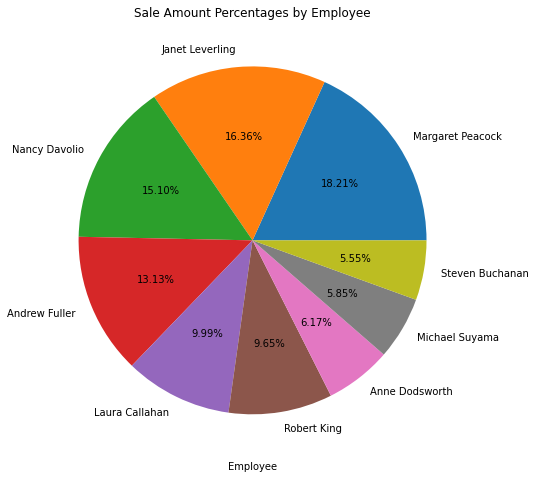

,TotalSaleAmount [$1k]
Name,
Margaret Peacock,225.763696
Janet Leverling,202.812843
Nancy Davolio,187.277384
Andrew Fuller,162.769780
Laura Callahan,123.842678
Robert King,119.619250
Anne Dodsworth,76.450067
Michael Suyama,72.527630
Steven Buchanan,68.792282


['Margaret Peacock', 'Janet Leverling', 'Nancy Davolio'] have the highest sale amounts.
['Steven Buchanan', 'Michael Suyama', 'Anne Dodsworth'] have the lowest sale amounts.


In [22]:
# prepare data for a pie plot to show sale amount portion by employee
df = df_revenue \
    .pivot_table(
        index = "Name",
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .sort_values("SaleAmount", ascending = False) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"})

# plot pie chart in descending order of total sale amount
XY = {"x": "Name", "y": "TotalSaleAmount [$1k]", "kind": "pie",
      "xlabel": "Employee", "ylabel": "", "title": "Sale Amount Percentages by Employee", "legend": False, 
      "autopct": "%.2f%%", "startangle": 0}
FIG = {"figsize": (8, 8)}
plotDF(df, XY, FIG=FIG)
plt.show()

# print the total sale amount
display(df)

print(
    f"{list(df.index)[:3]} have the highest sale amounts.\n"    
    f"{list(df.index)[:-4:-1]} have the lowest sale amounts.")

In order to visualize and  compare their sale performance easily, we plot the total sale amount (recognized from shipped orders) on the left y-axis (scatter plot with blue solid dots) and number of products on the right y-axis (green bar chart) in each product category for each employee. This allows us to see how much the individuals are selling as well as the diversity of products they sell. The subplots of each employee are in descending order of their total sale amount:

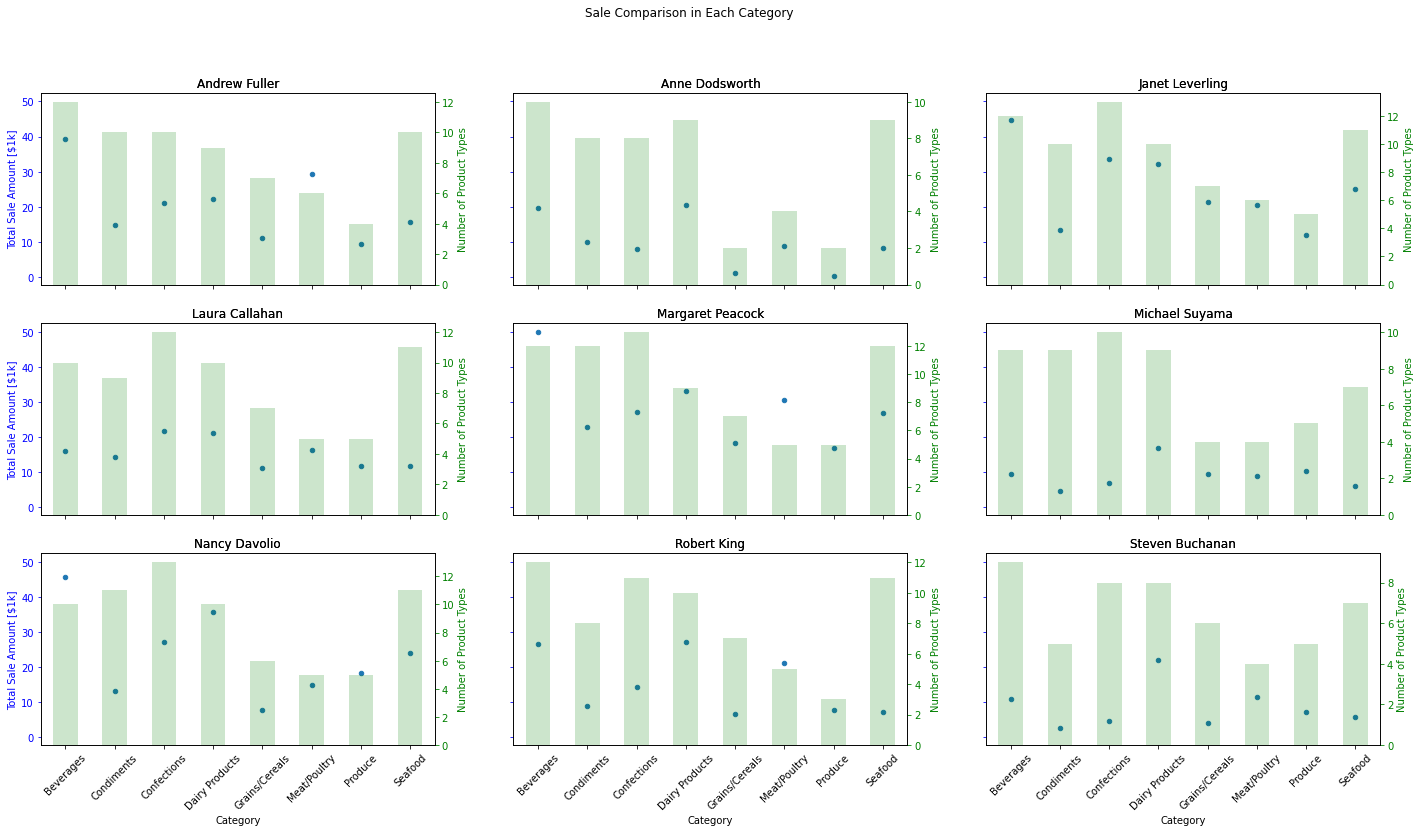

In [23]:
# prepare data for show sale amount and number of products in each category
df = df_revenue \
    .pivot_table(
        index = ["Name", "CategoryName"],
        values = ["ProductID", "SaleAmount"],
        aggfunc = {"ProductID": "nunique", "SaleAmount": lambda x: x.sum()/1000}) \
    .rename(columns={"ProductID": "Products", "SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index() 

# plot scatter and bar plots for total sale amount and number of products by employee
XY = {"x": "CategoryName", "y": "TotalSaleAmount [$1k]", "kind": "scatter", "rot": 45,
      "xlabel": "Category", "ylabel": "Total Sale Amount [$1k]"}
Y2 = {"y": "Products", "kind": "bar", 
      "ylabel": "Number of Product Types", "color": "green", "alpha": 0.2, "legend": False}
FIG = {"ncols": 3, "figsize": (24, 12), "sharex": True, "sharey": True}

plotDF(df, XY, Y2, FIG, by = "Name", suptitle = "Sale Comparison in Each Category")
plt.show()

It's easy to see that the Produce, and Meat/Poultry categories are the weakness for most of the employees. This is true even for our sale champions Margaret Peacock and Janet Leverling. These are two categories they need to improve, especially for Robert King, Nancy Davolio, and Anne Dodsworth in order to develop a more complete portfolio.

As for their strengths, all employees have good sales performance in Beverages, Confections and Dairy Products categories. This is not surprising, considering we've previously seen that Beverages and Dairy account for the majority of total sales revenue. Most of the employees also did well in Condiments category, except for Steven Buchanan who also has the lowest total sales for the whole team.

#### How have they done across years?
To get a sense of the longitudinal data, we now look at performance across the years accounted for in the data. When we plot the sale revenue by year, we notice that for most categories, the sale amount peaked in 1997:

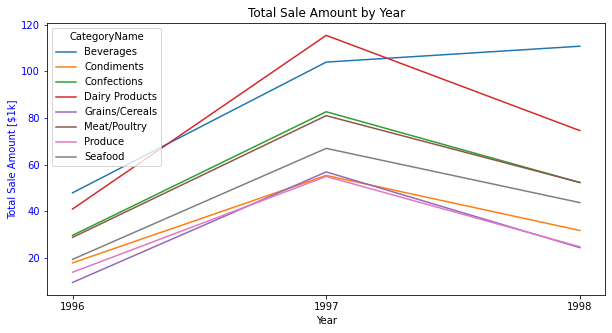

This is because the time durations are not the same across the years in our data. Recall that our data have all sale orders between 07/04/96 and 06/11/98. We do not have the 12-month sale order data in the first and the last year. Therefore, we believe it will be more approriate to aggregate sale amount by smaller duration like month or quarter.


In [24]:
# set the period duration
period = ["Year", "YearQuarter", "YearMonth"][0]

# prepare data to plot total sale amount in each category by period
df = df_revenue \
    .pivot_table(
        index = [period],
        columns = ["CategoryName"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index()

# line plot for total sale amount in each category by period
XY = {"x": period,  "kind": "line", "xticks": df[period].unique(),
      "xlabel": period, "ylabel": "Total Sale Amount [$1k]", "title": f"Total Sale Amount by {period}"}
FIG = {"figsize": (10, 5)}
plotDF(df, XY, FIG = FIG)
plt.show()

print(
    f"This is because the time durations are not the same across the years in our data. "
    f"Recall that our data have all sale orders between {date_begin.strftime('%x')} and {date_end.strftime('%x')}. "
    f"We do not have the 12-month sale order data in the first and the last year. "
    f"Therefore, we believe it will be more approriate to aggregate sale amount by smaller duration like month or quarter.")

Below is the plot of the sale revenue, aggregated by each quarter for a more accurate depiction:

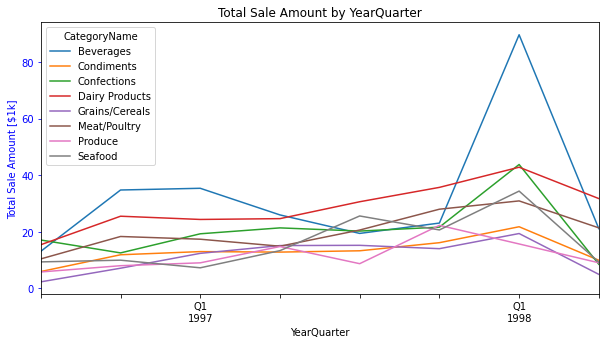

In [31]:
# set the period duration
period = ["Year", "YearQuarter", "YearMonth"][1]

# prepare data to plot total sale amount in each category by period
df = df_revenue \
    .pivot_table(
        index = [period],
        columns = ["CategoryName"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index()

# line plot for total sale amount in each category by period
XY = {"x": period,  "kind": "line", "xticks": df[period].unique(),
      "xlabel": period, "ylabel": "Total Sale Amount [$1k]", "title": f"Total Sale Amount by {period}"}
FIG = {"figsize": (10, 5)}
plotDF(df, XY, FIG = FIG)
plt.show()

In the first quarter of 1998, the sale amounts peaked in many categories including Beverages, Confections and Grains/Cereals. The sale decrease in the last period (Q2 1998) is probably due to the unshipped orders excluded from the recognized revenue calculation. Therefore, we will use the sale amount change between Q3 1997 and Q4 1998 as a metric for their near-term sale performance:

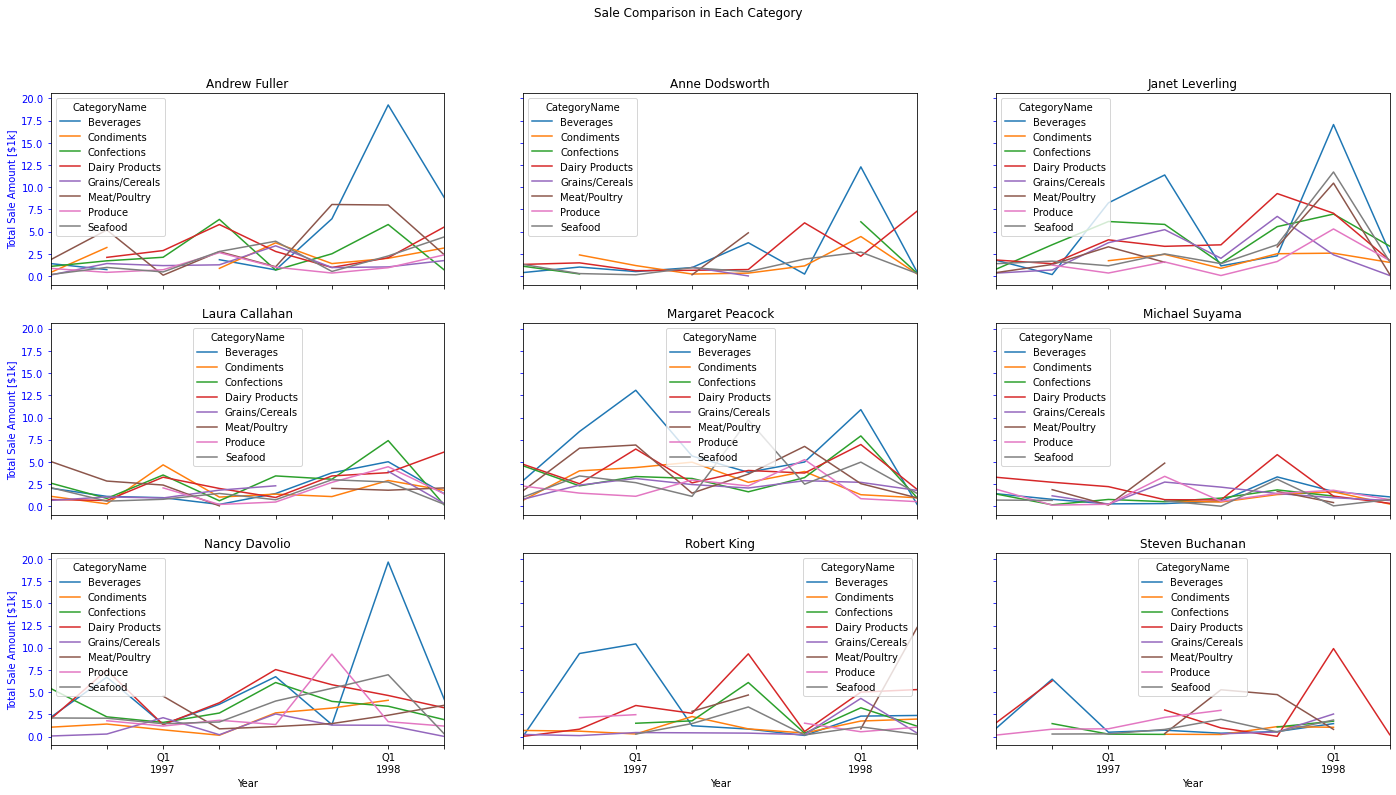

In [26]:
# prepare data to plot quarterly sale amount in each category by employee
df = df_revenue \
    .pivot_table(
        index = ["YearQuarter", "Name"],
        columns = ["CategoryName"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index() 

# line plots for quarterly sale amount in each category by employee
XY = {"x": "YearQuarter",  "kind": "line", "xticks": df["YearQuarter"].unique(),
      "xlabel": "Year", "ylabel": "Total Sale Amount [$1k]"}
FIG = {"ncols": 3, "figsize": (24, 12), "sharex": True, "sharey": True}
plotDF(df, XY, FIG = FIG, by = "Name", suptitle = "Sale Comparison in Each Category")
plt.show()

From the plots above, we can see Andrew Fuller, Janet Leverling, Nancy Davolio and Anne Dodsworth had contributed a a significant portion of this increase. On the other hand, Michael Suyama, Steven Buchanan and Laura Callahan failed to catch up the sales.

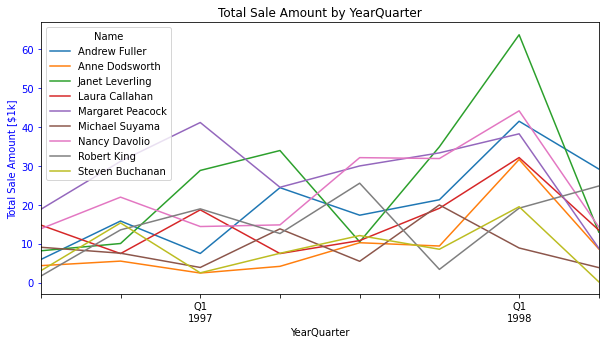

In [27]:
# set the period duration
period = ["Year", "YearQuarter", "YearMonth"][1]

# prepare data to plot total sale amount in each category by period
df = df_revenue \
    .pivot_table(
        index = [period],
        columns = ["Name"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index()

# line plot for total sale amount in each category by period
XY = {"x": period,  "kind": "line", "xticks": df[period].unique(),
      "xlabel": period, "ylabel": "Total Sale Amount [$1k]", "title": f"Total Sale Amount by {period}"}
FIG = {"figsize": (10, 5)}
plotDF(df, XY, FIG = FIG)
plt.show()

For the long term sale performance, Janet Leverling had the largest single sale increase from Q3 of 1997 to Q1 of 1998. Whereas Andrew Fullerha, Nancy Davolio and Margaret Peacock showed steadily increasing sales. Unfortunately,  Steven Buchanan had a constantly low sale amount.

#### How do they do in different regions
To get a comparison across categories and regions, we plot unstacked bar charts:

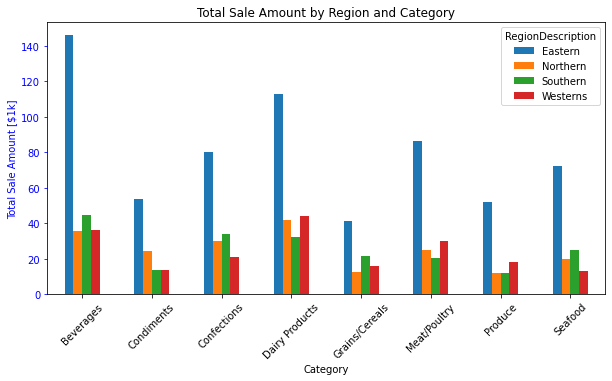

In [28]:
# prepare data to plot quarterly sale amount in each category by employee
df = df_revenue \
    .pivot_table(
        index = ["CategoryName"],
        columns = ["RegionDescription"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000 ) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index()

# line plots for quarterly sale amount in each category by employee
XY = {"x": "CategoryName", "kind": "bar", "rot": 45,
      "xlabel": "Category", "ylabel": "Total Sale Amount [$1k]", "title": "Total Sale Amount by Region and Category"}
FIG = {"figsize": (10, 5)}
plotDF(df, XY, FIG = FIG)
plt.show()

From this, we can clearly see the eastern region is the most important area in term of the total sale amounts. Its sale amounts are at least twice of those in the other region for all product categories, with the exception of Grains/Cereals. This implies that there is room for future growth of Grains/Cereals products in Eastern region. There are four employees covering the Eastern region while only one, two and two employees covering the Southern, Northern and Western regions, respectively. This could also account for the disparity, perhaps Northwind should consider increasing their involvement in these other regions as a possible business strategy for the company's growth in these areas.

To examine this trend on the individual level, we plot pie charts to show each employee's sale amount in each region below:

TotalSaleAmount [$1k]
RegionDescription Name             Title                    Tenure Territories                       
Eastern           Margaret Peacock Sales Representative     5.1    3                       225.763696
                  Nancy Davolio    Sales Representative     6.1    2                       187.277384
                  Andrew Fuller    Vice President, Sales    5.8    7                       162.769780
                  Steven Buchanan  Sales Manager            4.7    7                        68.792282
Northern          Laura Callahan   Inside Sales Coordinator 4.3    4                       123.842678
                  Anne Dodsworth   Sales Representative     3.6    7                        76.450067
Southern          Janet Leverling  Sales Representative     6.2    4                       202.812843
Westerns          Robert King      Sales Representative     4.4    10                      119.619250
                  Michael Suyama   Sales Representative     4.7    5                        72.527630

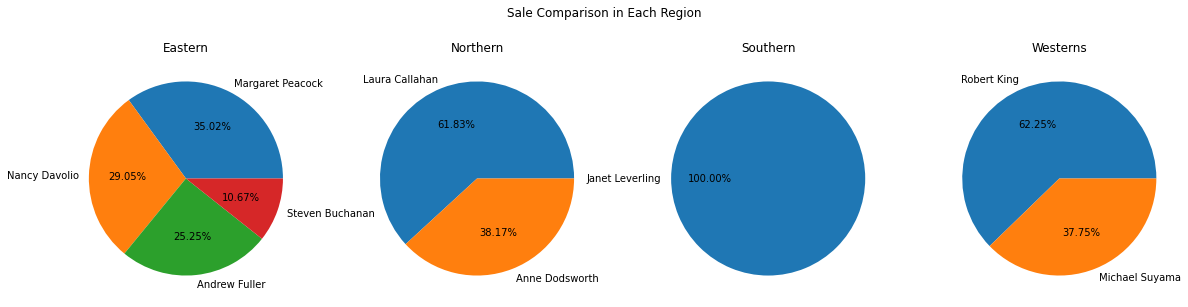

In [29]:
# prepare data for a pie plot to show sale amount portion by employee
df = df_revenue \
    .pivot_table(
        index = ["RegionDescription", "Name", "Title", "Tenure", "Territories"],
        values = "SaleAmount",
        aggfunc = lambda x: x.sum()/1000) \
    .sort_values(["RegionDescription", "SaleAmount"], ascending = [True, False]) \
    .rename(columns={"SaleAmount": "TotalSaleAmount [$1k]"}) \
    .reset_index()

display(df.sort_values("RegionDescription").set_index(["RegionDescription", "Name", "Title", "Tenure", "Territories"]))

# plot pie chart in descending order of total sale amount
XY = {"x": "Name", "y": "TotalSaleAmount [$1k]", "kind": "pie",
      "xlabel": "", "ylabel": "", "title": "Sale Amount Percentages by Employee", "legend": False, 
      "autopct": "%.2f%%", "startangle": 0}
FIG = {"ncols": 4, "figsize": (20, 5)}
plotDF(df.set_index("Name"), XY, FIG = FIG, by = "RegionDescription", suptitle = "Sale Comparison in Each Region")
plt.show()

As we've seen previously, this is a more interesting visualization for those regions where there are more than one salesperson, however we have included the Southern region as well to be exhaustive. We can see that Margaret Peacock is the best performer in the region with the largest share of the company's revenue. This falls in line with expectations, as she and Janet Leverling have been the salespeople with the highest sales in previous analyses. We see Steven Buchanan is under performing compared to his colleagues in Eastern region. Janet Leverling, who is the only person covering the Sourthern region, has achieved similar sale amounts with the two-people teams in the Northern and Western regions. 

### Part 4: Suggestions

At the individual level, we can see Andrew Fuller's sales on Beverages look outstanding compared to the other categories of his sales in 1998. He is also the top sales on this category in 1998 and the amount increased notably for himself compared to the prior two years' sales. Grains/Cereals and Produce can be his category of improvement.

Anne Dodsworth showed steady improving sales amount on Beverages and Dairy Products over the years, which are her strength. However, similar to Andrew, Anne might want to improve on sales of Grains/Cereals and Produce.

Janet Leverling's sales of Beverages improved significantly since 1997. Her sales of Confections, Dairy Products, and Grains/Cereals were also strong in 1997 but somehow dropped in 1998. Her sales of Seafood, Meant/Poultry, and Produce has been increasing steadily. Based on the performance in 1998, Grains/Cereals and Condiments could be the category for her to improve on.

Laura Callahan's overall performance is lower compared with the rest of the employees as she does not seem to be outstanding in selling any of the products. Relatively, Confections and Dairy Products seem to be her strength. Laura can improve on Seafood, Meat/Poultry and Grains/Cereals.

Margaret Peacock's sales dropped notably in 1998 compared to the numbers in 1997. Based on the three years' statistics, Beverages seems to be her strength. Condiments and Produce and Meat/Poultry dropped a lot from 1997 to 1998 and can be her categories for improvement.

Michael Suyama's sales improved overall from 1996 to 1997 but dropped on all categories from 1997 to 1998. Dairy Products used to be his strength but somehow the sales was poor in 1998. Produce looks overall okay so seems to be Michael's recent strength. He can improve on bring his sales on Meat/Poultry, Seafood, Confections and Dairy Products back to track.  

Nancy Davolio's sales showed strong increase on Beverages over the years, which appears to be her strength. She can improve on Grains/Cereals, Condiments and Produce based on her statistics trend from 1996 to 1998.

Robert King was performing very well on Dairy Products and Beverages in 1997 but the sales dropped in 1998. His recent strength appears to be Meat/Poultry. While keeping his performance strong on Meat/Poultry and Dairy Products, he should consider improving sales on Seafood.

Steven Buchanan's sales is also relatively weak overall compared to the other employees. His performance on Meat/Poultry and Produce was relatively good in 1997 but both dropped significantly in 1998, which he might want to improve on in the following years. Dairy Products seem to be his strength.

For a more macro strategy, as previously mentioned there is room for further development in the Northern, Southern, and Western regions. Hiring more sales people to provide high coverage could increase the potential for sales growth in the areas. While the Eastern region is performing well, an increase in the advertising of grains/cereal products could also improve those regional numbers, as that is the category with the lowest numbers. There is also room for improvement in the categories of produce and condiments in all regions. Some investigation as to why these areas are under performing could be worthwhile to increase revenues. An increase in advertising, or perhaps updating and diversifying the offerings of these categories could yield desirable results. 